In [ ]:
!pip install tensorflow.keras
!pip install tavily
!pip install selenium
!pip install langchain-openai langchain-core langchain

  Preparing metadata (setup.py) ... done
  Created wheel for tavily: filename=tavily-1.1.0-py3-none-any.whl size=6128 sha256=beb3ad6841281b960daf587d48f0c880d82a7f3ea0c2ab73b76ca8d77d48137d
  Stored in directory: /root/.cache/pip/wheels/a7/67/b7/9aec4851724de28ac2bc34ff10b042af43d7f2dd1552e5906e
Successfully built tavily


In [ ]:
pip install openai-clip torch torchvision pillow pinecone tqdm langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.9/745.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.0/473.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=65a4f803a0d1c5ec87fa319257b5dc5696a0b1dfdc262ec97badc92b35d3af17
 

Instantiated the CLIP VLM

In [ ]:
import torch
import clip
import PIL.Image
from tqdm import tqdm
from pinecone import Pinecone, ServerlessSpec
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
modeli, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.3MiB/s]


Converting the Dataset Images into Vectors embeddings

In [ ]:
import os
image_folder = "/content/drive/MyDrive/Dataset/Normal-skin"
image_vectors = []

for filename in tqdm(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        image = preprocess(PIL.Image.open(image_path)).unsqueeze(0).to(device)


        with torch.no_grad():
            image_features = modeli.encode_image(image)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        vector = image_features.cpu().numpy().flatten().tolist()

        image_vectors.append({
            "id": filename,
            "values": vector,
            "metadata": {"Disease": "Normal"}
        })

KeyboardInterrupt: 

Instantiated the Index in the PineCone Vector Database.

In [ ]:
pc = Pinecone(api_key="pcsk_734a9H_98bCfspdWWc4XgFoZBPsYB2CNw498LBK53KNDyF1WjVGsBcN8rsTzSYVWCc1GkQ")  #pcsk_xEske_CL1K1Kxm8Zu2ncNFPaVW9TKroYJHYJn7KYb6Vtug66GUF5q8mFPLN9JbpWkGhgP

index_name = "skindisease-symptoms-gpt-4"

# Create new index if it doesn’t exist
if index_name not in [i["name"] for i in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=512,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


Uploaded the Vect

In [ ]:
# Batch upsert
for i in range(0, len(image_vectors), 100):
    batch = image_vectors[i:i+100]
    index.upsert(vectors=batch)

print(f"✅ Uploaded {len(image_vectors)} image embeddings to Pinecone")


In [ ]:

#if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#image_path = os.path.join(image_folder, filename)
def RAG(image,index_name,api):
  image = preprocess(PIL.Image.open(image)).unsqueeze(0).to(device)
  pc = Pinecone(api_key=api)
  index = pc.Index(index_name)
  with torch.no_grad():
      image_features = modeli.encode_image(image)

  image_features /= image_features.norm(dim=-1, keepdim=True)
  query_vector = image_features.cpu().numpy().flatten().tolist()
  results = index.query(
      vector=query_vector,
      top_k=1,
      include_metadata=True
  )
  results = results["matches"]
  return results

INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27


In [ ]:
from pydantic import BaseModel
from typing import Optional,List
from typing import Annotated
import operator
class State(BaseModel):
  image: Optional[str] = None
  eligible:bool=False
  age: Optional[str] = None
  gender: Optional[str] = None
  bauman_type: Annotated[str, operator.add]
  skin_disease: Optional[str] = None
  meds: Annotated[List[str], operator.add] = []
  medimage: Annotated[List[str], operator.add] = []
  des: Optional[str] = None
  toxic: Optional[str] = None

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

# Initialize client with your API key
llm = ChatOpenAI( # Renamed instance for clarity
      api_key="sk-proj-...",
      model="gpt-4o-mini",  # You can use "gpt-4o", "gpt-5", etc.
      temperature=0.0)

# Chat completion example
def chat(state:State):
  messages=[
          SystemMessage(content="Act as a loreal paris skin care product recommender."),
          HumanMessage(content=f"Please suggest a loreal skin care product for a {state.gender} of age {state.age} and skin type is {state.bauman_type}.")
      ]

  chat_response = llm.invoke(messages) # Corrected call and assigned to a new variable
  return {'des':chat_response.content} # Return the content

# The print statement and function call should be after the function definition
#result = chat(state)
#print(result)

In [ ]:
from tavily import TavilyClient
client = TavilyClient(api_key="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")
def websearch():
  response = client.search(f"Please suggest a loreal skin care product for a boy of age 16 and skin type is oily, pigmented, sensitive, wrinkle.") # Give only lorealparisusa websites
  response['results'][0]['url']
  print(response['results'])


In [ ]:
websearch()

[{'url': 'https://www.quora.com/Which-products-should-a-16-year-old-with-combination-skin-use-for-skin-care', 'title': 'Which products should a 16-year-old with combination skin ...', 'content': "A good hydrating gel moisturizer that won't make your skin oily but still hydrate the skin. And lastly a good sunscreen with SPF 50 protection.", 'score': 0.99987566, 'raw_content': None}, {'url': 'https://www.amazon.com/loreal-youth-code-serum/s?k=loreal+youth+code+serum', 'title': 'Loreal Youth Code Serum', 'content': "L'Oreal Paris Revitalift 1.5% Pure Hyaluronic Acid Serum for Face, Anti Aging Serum to Hydrate Skin & Reduce Wrinkles, Fragrance Free Skin Care for All Skin", 'score': 0.99921453, 'raw_content': None}, {'url': 'https://www.youtube.com/watch?v=enX_NeDzzG4', 'title': "30+ Skincare: L'Oréal Youth Code Rejuvenating Anti- Wrinkle ...", 'content': 'This product will definitely work for you it will moisturize smooth and give this really refreshing effect to your face.', 'score': 0.99

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 33.6 MB/s eta 0:00:00


In [ ]:
import re
import html
import urllib.parse
from pathlib import Path
import requests
from PIL import Image
import io
import hashlib
import csv
import logging
import hashlib
import io
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver import ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from pathlib import Path
from PIL import Image
import time
import urllib.parse
import sys
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

INPUT_HTML = Path("output.html")
IMAGES_DIR = Path("images")
CSV_OUT = Path("products.csv")
HTML_OUT = Path("products_gallery.html")
SITE_BASE = "https://www.lorealparisusa.com/skin-care/anti-aging?page=4"

ModuleNotFoundError: No module named 'selenium'

In [ ]:
def parse_products_from_html_text(text: str):
    """
    Extract product records by searching for patterns observed in your output.html:
    - title&quot;:&quot;...
    - priceNumber&quot;:&quot;...
    - fileName&quot;:&quot;...  (image path)
    Optionally: shortDescription&quot;:&quot;...
    We'll iterate over every priceNumber occurrence and try to find the nearest title and fileName.
    """
    products = []
    # find all priceNumber occurrences (escaped JSON-like)
    price_pat = re.compile(r'priceNumber&quot;\s*:\s*&quot;([^&"]+)&quot;', re.IGNORECASE)
    title_pat = re.compile(r'title&quot;\s*:\s*&quot;([^&"]+)&quot;', re.IGNORECASE)
    alt_title_pat = re.compile(r'productTitle&quot;\s*:\s*&quot;([^&"]+)&quot;', re.IGNORECASE)
    file_pat = re.compile(r'fileName&quot;\s*:\s*&quot;([^&"]+)&quot;', re.IGNORECASE)
    short_desc_pat = re.compile(r'shortDescription&quot;\s*:\s*&quot;([^&"]+)&quot;', re.IGNORECASE)

    # Positions for quick lookup: create lists of occurrences with positions
    price_matches = list(price_pat.finditer(text))
    title_matches = list(title_pat.finditer(text)) + list(alt_title_pat.finditer(text))
    file_matches = list(file_pat.finditer(text))
    short_desc_matches = list(short_desc_pat.finditer(text))

    logging.info("Found %d prices, %d titles, %d fileNames, %d shortDescriptions",
                 len(price_matches), len(title_matches), len(file_matches), len(short_desc_matches))

    # For each price occurrence, find nearest title and fileName by proximity
    for pm in price_matches:
        price = pm.group(1).strip()
        pos = pm.start()

        # find nearest title before this price (search within 600 chars window)
        window_start = max(0, pos - 800)
        window_end = pos + 400
        context = text[window_start:window_end]

        t = title_pat.search(context)
        if not t:
            t = alt_title_pat.search(context)
        title = html.unescape(t.group(1)).strip() if t else ""

        # find fileName in the same window
        f = file_pat.search(context)
        if not f:
            # try find fileName slightly after price as well
            f = file_pat.search(text[pos:pos+800])
        file_name = f.group(1).strip() if f else ""

        # short description (optional) - search around price
        sd = short_desc_pat.search(context)
        short_desc = html.unescape(sd.group(1)).strip() if sd else ""

        # normalize image URL
        image_url = ""
        if file_name:
            # file_name may be something like '/-/media/...png'
            if file_name.startswith("/"):
                image_url = urllib.parse.urljoin(SITE_BASE, file_name)
            elif file_name.startswith("http"):
                image_url = file_name
            else:
                image_url = urllib.parse.urljoin(SITE_BASE, "/" + file_name.lstrip("/"))

        # Avoid duplicates: if title already present with same price, skip
        products.append({
            "title": title,
            "price": price,
            "shortDescription": short_desc,
            "image_url": image_url
        })

    # Post-process: remove empty records and dedupe by (title, price)
    seen = set()
    out = []
    for p in products:
        key = (p["title"] or "").lower().strip(), (p["price"] or "").strip()
        if key in seen:
            continue
        if not p["title"] and not p["image_url"]:
            continue
        seen.add(key)
        out.append(p)
    logging.info("After cleanup: %d product records", len(out))
    return out

In [ ]:
import requests
from bs4 import BeautifulSoup


# Now call the modified parse_products_from_html_text with the fetched content
text = INPUT_HTML.read_text(encoding="utf-8")
products = parse_products_from_html_text(text)
products = parse_products_from_html_text()
print(products)

FileNotFoundError: [Errno 2] No such file or directory: 'output.html'

In [ ]:
import re
def extract(state:State):
  matches = re.findall(r"\*\*(.*?)\*\*", state.des)
  return({'meds':matches})
#matches=extract(result)

In [ ]:
from tavily import TavilyClient
client = TavilyClient(api_key="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")
def websearch(state:State):
  url=[]
  for i in state.meds:
    response = client.search(f"Show image of {i}",include_images=True) # Give only lorealparisusa websites
    url.append(response['results'][0]['url'])
  return {'medimage':url}
#websearch('loreal charcoal')

In [ ]:
def examiner(state:State):
  #for i in len(ingrediants)-1:
   # j = i+1
  messages=[
          SystemMessage(content="Act as a skin care specialist aware of harmful ingredients in skincare products that are harmfull to skin."),
          HumanMessage(content=f"Please state the anti toxic products to each other {state.meds}. State if the products can be used together. If not state which ones should not be used together and only from the given products list only.")
      ]

  chat_response = llm.invoke(messages) # Corrected call and assigned to a new variable
  return {'toxic': chat_response.content} # Return the content

In [ ]:
skinapi="pcsk_xEske_CL1K1Kxm8Zu2ncNFPaVW9TKroYJHYJn7KYb6Vtug66GUF5q8mFPLN9JbpWkGhgP"

def skin_disease(state: State):
    result = RAG(
        image=state.image,
        index_name="clip-skd",
        api=skinapi
    )

    disease = result[0]["metadata"]["Disease"]

    if disease == "Normal":
        return "normal"
    else:
        return "abnormal"

#skin_disease()

In [ ]:
def com(state: State):
    return {"Eligible": True}

In [ ]:
def skin_disease_reduce(state:State):
  if RAG(state.image,"skindisease-symptoms-gpt-4","pcsk_734a9H_98bCfspdWWc4XgFoZBPsYB2CNw498LBK53KNDyF1WjVGsBcN8rsTzSYVWCc1GkQ")[0]['score']<0.55:
    return {"skin_disease":''}
  return {"skin_disease":RAG(state.image,"skindisease-symptoms-gpt-4","pcsk_734a9H_98bCfspdWWc4XgFoZBPsYB2CNw498LBK53KNDyF1WjVGsBcN8rsTzSYVWCc1GkQ")[0]['metadata']['Disease']}



In [ ]:
RAG('/content/aishwarya-rai-bachchan_14.jpg',"skindisease-symptoms-gpt-4","pcsk_734a9H_98bCfspdWWc4XgFoZBPsYB2CNw498LBK53KNDyF1WjVGsBcN8rsTzSYVWCc1GkQ")[0]

{'id': '18',
 'metadata': {'Disease': 'acne'},
 'score': 0.527628541,
 'values': []}

In [ ]:
def oily(state:State):
  return {"bauman_type":f"{RAG(state.image,"clip-image-index",skinapi)[0]['metadata']['filename'].split("_")[0]} "}

In [ ]:
def sense(state:State):
  if RAG(state.image,"clip-sens",skinapi)[0]['metadata']['filename'].split("_")[0]=='normal':
    return {"bauman_type":"resistant "}
  else:
    return {"bauman_type":"sensitive "}

In [ ]:
def pig(state:State):
  if RAG(state.image,"clip-pig",skinapi)[0]['metadata']['filename'].split("_")[1]=='png':
    return {"bauman_type":'pigmentation '}
  else:
    return {"bauman_type":'non-pigmentation '}

In [ ]:
def wri(state:State):
  if RAG(state.image,"clip-wri",skinapi)[0]['metadata']['filename'][0]=='w':
    return {"bauman_type":'wrinkle'}
  else:
    return {"bauman_type":'tight'}

In [ ]:
gender_dict = {0:"Male",1:"Female"}
def category(age):
  if age>=0 and age<18:
    age="Child"
  elif age>=18 and age<30:
    age="Adult"
  elif age>=30 and age <50:
    age="Man"
  elif age>=50 and age<100:
    age="Old"
  return age

In [ ]:
import joblib
import numpy as np
import PIL.Image # Changed from 'from PIL import Image'
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

def age(state:State):
  # Load the image as grayscale and resize
  model = load_model("/content/drive/MyDrive/aagp.keras")
  img = load_img(state.image, color_mode="grayscale", target_size=(128, 128))
  img = np.array(img)

  # Reshape to add batch dimension and channel dimension for Keras model input
  # Expected shape is (batch_size, height, width, channels)
  img = img.reshape(1, 128, 128, 1)

  pred = model.predict(img)
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0]/100)
  return {'gender':pred_gender,'age':category(pred_age)}

IMP

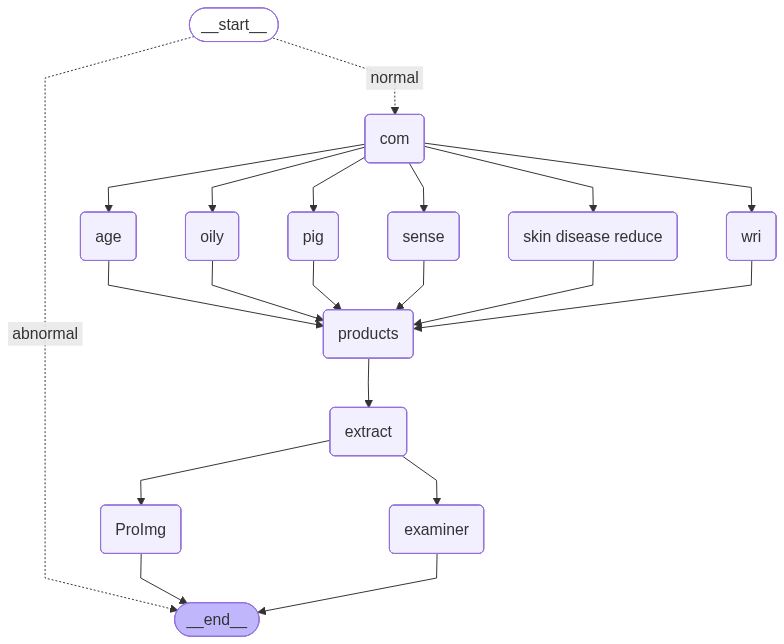

In [ ]:
builder = StateGraph(State)
builder.add_node("skin disease reduce", skin_disease_reduce)
builder.add_node("com", com)
builder.add_node("oily", oily)
builder.add_node("sense", sense)
builder.add_node("pig", pig)
builder.add_node("wri", wri)
builder.add_node("age", age)
builder.add_node("products", chat)
builder.add_node("extract", extract)
builder.add_node("examiner", examiner)
builder.add_node("ProImg", websearch)

builder.add_conditional_edges(
    START,
    skin_disease,
    {
        "normal": "com",
        "abnormal": END
    }
)
builder.add_edge("com", "skin disease reduce")
builder.add_edge("com", "oily")
builder.add_edge("com", "sense")
builder.add_edge("com", "pig")
builder.add_edge("com", "wri")
builder.add_edge("com", "age")
builder.add_edge("skin disease reduce", "products")
builder.add_edge("oily", "products")
builder.add_edge("sense", "products")
builder.add_edge("pig", "products")
builder.add_edge("wri", "products")
builder.add_edge("age", "products")
builder.add_edge("products", "extract")
builder.add_edge("extract", "ProImg")
builder.add_edge("ProImg", END)
builder.add_edge("extract", "examiner")
builder.add_edge("examiner", END)

graph = builder.compile()
import IPython.display
display(IPython.display.Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"image": '/content/aishwarya-rai-bachchan_14.jpg'})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


In [ ]:
messages

{'image': '/content/aishwarya-rai-bachchan_14.jpg',
 'age': 'Child',
 'gender': 'Female',
 'bauman_type': 'oily non-pigmentation resistant tight',
 'skin_disease': '',
 'meds': ["L'Oréal Paris Hydra Genius Daily Liquid Care"],
 'medimage': ['https://moustaphalabban.com/products/loreal-paris-hydra-genius-daily-liquid-care-pnm?srsltid=AfmBOopq7ckco7vBjj9yi8C9YTbRkz-9EfiiTAfO1cHwlcsdnckvothH'],
 'des': "For a child with oily skin that is non-pigmentation resistant and feels tight, it's important to choose gentle, hydrating products that won't exacerbate oiliness or irritation. While L'Oréal Paris primarily targets adult skincare, their products can sometimes be suitable for younger skin, especially if they are formulated for sensitive or oily skin types.\n\nI recommend the **L'Oréal Paris Hydra Genius Daily Liquid Care** for Normal/Oily Skin. This product is lightweight and provides hydration without clogging pores, which is ideal for oily skin. It contains aloe water and hyaluronic acid,

In [ ]:
from langgraph.graph import START, END, StateGraph
builder = StateGraph(State)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

ModuleNotFoundError: No module named 'langgraph'

In [ ]:
# def ing(matches):
#   ingrediants=[]
#   for i in matches:
#     messages=[
#             SystemMessage(content="Act as a loreal paris skin care products ingrediants examiner."),
#             HumanMessage(content=f"Please state the ingrediants of {i}.")
#         ]

#     chat_response = llm.invoke(messages) # Corrected call and assigned to a new variable
#     print(chat_response.content)
#     ingrediants.append(chat_response.content) # Return the content
#   return(ingrediants)
# ingrediants=ing(matches)
# print(ingrediants)

In [ ]:
import requests
url='https://www.lorealparisusa.com/skin-care/oily-skin'
data  = requests.get(url).text
from bs4 import BeautifulSoup
soup = BeautifulSoup(data,"html")
requests.get(url)

<Response [200]>

In [ ]:
table = soup.find_all("article")#, attrs={"alt": "071249135655_T1"})
#print(table)
# f=[]
# do=[]
# a=table.find_all('tr')
# for row in a: # in html table row is represented by the tag <tr>
#     # Get all columns in each row.
#     d=row.find_all('td')
#     try:
#         f.append(d[0].string)
#         do.append(d[1].string)
#     except:
#         pass
# da={'Date':f,"Revenue":do}
# tesla_revenue=pd.DataFrame(da)
# tesla_revenue["Revenue"]
table

[<article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <div class="filterGrid__itemWrapper">
 </div>
 </article>,
 <article class="filterGrid__item">
 <di

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pro

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import time
import os

mp_face = mp.solutions.face_detection

def compute_contrast(roi_bgr, use_clahe=True):
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
    return float(np.std(gray))

def color_for_contrast(c, low=25.0, high=60.0):
    # Tune low/high or make dynamic
    if c < low:
        return (0, 0, 255), "Low"      # Red (BGR)
    elif c < high:
        return (0, 255, 255), "Medium" # Yellow
    else:
        return (0, 255, 0), "High"     # Green

def smooth_box(prev, curr, alpha=0.6):
    if prev is None:
        return curr
    x = int(alpha * prev[0] + (1-alpha) * curr[0])
    y = int(alpha * prev[1] + (1-alpha) * curr[1])
    w = int(alpha * prev[2] + (1-alpha) * curr[2])
    h = int(alpha * prev[3] + (1-alpha) * curr[3])
    return (x, y, w, h)

def capture_face_contrast_mediapipe(save_path="face_contrast.jpg"):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        return

    prev_boxes = []  # store previous boxes to smooth per-index (simple)
    smoothing_alpha = 0.6
    detector = mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.6)

    print("Press SPACE to capture, ESC to quit")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = detector.process(rgb)

        boxes = []
        scores = []

        if results.detections:
            for det in results.detections:
                bbox = det.location_data.relative_bounding_box
                x = int(bbox.xmin * w)
                y = int(bbox.ymin * h)
                bw = int(bbox.width * w)
                bh = int(bbox.height * h)

                # expand a little to include hair/forehead if desired
                pad_x = int(0.1 * bw)
                pad_y = int(0.15 * bh)
                x1 = max(0, x - pad_x)
                y1 = max(0, y - pad_y)
                x2 = min(w, x + bw + pad_x)
                y2 = min(h, y + bh + pad_y)
                boxes.append((x1, y1, x2-x1, y2-y1))
                scores.append(float(det.score[0]) if det.score else 0.0)

        # simple smoothing: match by index (MediaPipe usually keeps order stable)
        smoothed = []
        for i, box in enumerate(boxes):
            prev = prev_boxes[i] if i < len(prev_boxes) else None
            sm = smooth_box(prev, box, alpha=smoothing_alpha)
            smoothed.append(sm)
        prev_boxes = smoothed

        # Draw boxes and compute contrast per face
        for (x, y, bw, bh) in smoothed:
            # Ensure ROI inside image
            x2 = min(w, x + bw)
            y2 = min(h, y + bh)
            roi = frame[y:y2, x:x2].copy()
            if roi.size == 0:
                continue
            contrast = compute_contrast(roi, use_clahe=True)
            color, status = color_for_contrast(contrast, low=25.0, high=60.0)

            # Draw rectangular outline
            cv2.rectangle(frame, (x, y), (x2, y2), color, 2)

            # Draw filled indicator bar above the box
            bar_h = 28
            cv2.rectangle(frame, (x, max(0,y-bar_h)), (x+160, y), color, -1)
            label = f"{status} {contrast:.1f}"
            cv2.putText(frame, label, (x+6, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)

        cv2.imshow("Face Contrast (MediaPipe)", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC
            break
        elif key == 32:  # SPACE
            # save current frame
            abs_path = os.path.abspath(save_path)
            cv2.imwrite(abs_path, frame)
            print("Saved:", abs_path)

    detector.close()
    cap.release()
    cv2.destroyAllWindows()

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog

def capture_face_contrast():
    while True:
        print("\nChoose an option:")
        print("1️⃣ Capture face from camera")
        print("2️⃣ Upload existing image")
        choice = input("Enter 1 or 2: ").strip()
        if choice == "2":
            root = tk.Tk()
            face_cascade = cv2.CascadeClassifier(
                cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
            )

            root = tk.Tk()
            root.withdraw()                    # create/withdraw root once

            while True:
                file_path = filedialog.askopenfilename(
                    title="Select an Image",
                    filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")],
                    parent=root
                )
                if not file_path:
                    print("❌ No file selected. Exiting.")
                    break

                frame = cv2.imread(file_path)
                if frame is None:
                    print("❌ Could not read image. Try another.")
                    continue


                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

                for (x, y, w, h) in faces:
                    face_roi = gray[y:y+h, x:x+w]
                    contrast = np.std(face_roi)
                    if contrast < 30:
                        color, status = (0, 0, 255), "Low"
                    elif contrast < 60:
                        color, status = (0, 255, 255), "Medium"
                    else:
                        color, status = (0, 255, 0), "High"

                    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)
                    cv2.putText(frame, f"Contrast: {contrast:.1f} ({status})",
                                (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

                cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
                cv2.imshow("Image", frame)
                print("Press SPACE to select another file, ESC to exit.")

                k = cv2.waitKey(0) & 0xFF   # blocks until keypress while window has focus
                cv2.destroyWindow("Image")  # remove window before next dialog/loop

                if k == 27:                 # ESC -> exit
                    print("Exiting (ESC).")
                    break

                elif k == 32:               # SPACE -> loop again (select another file)
                    print("Select another image (SPACE pressed).")
                    continue
                else:
                    print(f"Exiting (key {k} pressed).")
                    break
            break
        if choice == "1":
             capture_face_contrast_mediapipe("C:/Users/manin/Desktop/face_contrast.jpg")
             break
        else:
            print("choose 1 or 2 only.")
            continue


capture_face_contrast()



Choose an option:
1️⃣ Capture face from camera
2️⃣ Upload existing image
Enter 1 or 2: 2


TclError: no display name and no $DISPLAY environment variable